# Imports 

In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math
import random
from optparse import OptionParser

sys.path.append('/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list, make_ratio_plot

import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

     
print(sys.version)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import pandas as pd
import pickle as pickle
import shlex
import uproot
import seaborn as sns

from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

from prettytable import PrettyTable
from pyjet import cluster

import xgboost as xgb
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [2]:
# root settings
rt.gROOT.SetBatch(True)
rt.gStyle.SetOptStat(0)
rt.gStyle.SetOptFit(111)
rt.gStyle.SetPaintTextFormat("2.1f")

# plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "cm"

# test_name = 'xgb_HH_vs_QCD_ebBDT'

lumi_sf_sig = 137.0 # scale lumi from sample to full run2
lumi_sf_bkg = 137.0

#output dir

plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20201015/Data/3years/'

os.system("mkdir -p "+ plotDir)

0

# ALL BKG TAG EFF

In [3]:
tags = []
tags = [
    


        'Data 2016B-F',
        'Data 2016G-H',
        'Data 2017',
        'Data 2018',
        ]


# directory
home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/'
# file names

fnames = {}

fnames['Data 2016B-F'] = 'V1p17/v20/Data2016/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016B-F-HighMET-07Aug17_GoodLumi.root'
fnames['Data 2016G-H'] = 'V1p17/v20/Data2016/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016G-H-HighMET-07Aug17_GoodLumi.root'
fnames['Data 2017'] = 'V1p17/v20/Data2017/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-HighMET-17Nov2017_GoodLumi.root'
fnames['Data 2018'] = 'V1p17/v20/Data2018/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2018_Run2018-HighMET-17Sept2018_GoodLumi.root'


# get all the trees
tree = OrderedDict()

for tag in tags:
    print(home_dir+fnames[tag])

    root_dir = uproot.open(home_dir+fnames[tag])
    tree[tag] = root_dir['SusyLLPTree']

    print ('Open ready')
    print(tag)
    print ('Tree ready')
    print(tree[tag], tree)
    v = tree[tag]
    jet_amax = v['jetGammaMax_ET'].array()
    print(jet_amax[:10])
    jet_amax = v['weight'].array()
    print(jet_amax[:10])
    print(np.unique(jet_amax))
     


/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v20/Data2016/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016B-F-HighMET-07Aug17_GoodLumi.root
Open ready
Data 2016B-F
Tree ready
<TTree b'SusyLLPTree' at 0x7f3df3fcddd8> OrderedDict([('Data 2016B-F', <TTree b'SusyLLPTree' at 0x7f3df3fcddd8>)])
[[0.0060166237] [0.60657066 0.5776966] [] ... [0.21450968 0.7953685] [0.46687952 0.73789394] [0.30604082]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.]
/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v20/Data2016/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016G-H-HighMET-07Aug17_GoodLumi.root
Open ready
Data 2016G-H
Tree ready
<TTree b'SusyLLPTree' at 0x7f3dc4ffa7b8> OrderedDict([('Data 2016B-F', <TTree b'SusyLLPTree' at 0x7f3df3fcddd8>), ('Data 2016G-H', <TTree b'SusyLLPTree' at 0x7f3dc4ffa7b8>)])
[[0.013485471] [0.25269294 0.31258914 0.33876932] [0.5841571] ... [0.1851572] [0.38834184 0.44768518 0.5744957 0.3

# Tag Eff Measurement Region

In [6]:
trg_path=310
njet_cut=-1
met_cut=200
mdphi_cut=0.5
veto=1

mt_cut=100
# mt_cut=80

# jet_eta_cut=2.4
jet_eta_cut=1.48
jet_pt_cut=30
jet_time_cut=-1
jet_phoef_cut=0.8
jet_muef_cut=0.6
jet_eleef_cut=0.6


trg_jet_met = {}
trg_jet_rho = {}
trg_jet_nj = {}
trg_jet_mt = {}
trg_jet_ht = {}
trg_jet_mdphi = {}
trg_jet_w = {} 

trg_jet_dnn = {}

trg_jet_pt = {}
trg_jet_eta = {}
trg_jet_e = {}
trg_jet_phi = {}

trg_jet_chef = {}
trg_jet_muef = {}
trg_jet_eleef = {}
trg_jet_phoef = {}

trg_jet_nhef = {}
trg_jet_cemef = {}
trg_jet_nemef = {}

trg_jet_tmf = {}
trg_jet_dr = {}
trg_jet_time = {}


for k,v in tree.items():
    print(k,v)

    # branches
    met = v['met'].array()
    rho = v['rho'].array()
#     mt = v['MT_'].array()
    ht = v['HT'].array()
#     mdphi = v['jetMet_dPhi'].array()
    mdphi = v['jetMet_dPhiMin'].array()
    hlt = v['HLTDecision'].array()[:,trg_path]
    nj = v['nJets'].array()
    nlep = v['nLeptons'].array()
    nmu = v['nMuons'].array()
    nele = v['nElectrons'].array()
    ntau = v['nTaus'].array()
    npho = v['nPhotons'].array()
    
    mt = v['MT'].array()
    
    #flags
    flag1 =  v['Flag2_globalSuperTightHalo2016Filter'].array()
#     flag2 =  v['Flag2_globalTightHalo2016Filter'].array() 
#     flag3 =  v['Flag2_goodVertices'].array()
#     flag4 =  v['Flag2_BadChargedCandidateFilter'].array() 
    flag5 =  v['Flag2_BadPFMuonFilter'].array() 
    flag6 =  v['Flag2_EcalDeadCellTriggerPrimitiveFilter'].array() 
    flag7 =  v['Flag2_HBHENoiseFilter'].array() 
    flag8 =  v['Flag2_HBHEIsoNoiseFilter'].array() 
    flag9 =  v['Flag2_ecalBadCalibFilter'].array() 
    flag10 =  v['Flag2_eeBadScFilter'].array() 
    
    #jet var
    pt = v['jetPt'].array()
    eta = v['jetEta'].array()
    e = v['jetE'].array()
    phi = v['jetPhi'].array()
    dnn = v['jetDNNScore'].array()
    
    chef = v['jetChargedHadronEnergyFraction'].array()
    muef = v['jetMuonEnergyFraction'].array()
    eleef = v['jetElectronEnergyFraction'].array()
    phoef = v['jetPhotonEnergyFraction'].array()
    
#     nhef = v['jetNeutralHadronEnergyFraction'].array()
#     cemef = v['jetNeutralEMEnergyFraction'].array()
#     nemef = v['jetNeutralEMEnergyFraction'].array()
 
    tmf = v['jetGammaMax_ET'].array()
    dr = v['jetMinDeltaRPVTracks'].array()
    time = v['jetTime'].array()

    weight = v['weight'].array()
    
    print(weight.shape)
    
    #selection
    
    sel_hlt_triggered = 1
    sel_hlt_str  = np.logical_and(sel_hlt_triggered, hlt)
    
    sel_flag_str = np.logical_and(flag1, flag5)
    sel_flag_str = np.logical_and(sel_flag_str, flag6)
    sel_flag_str = np.logical_and(sel_flag_str, flag7)
    sel_flag_str = np.logical_and(sel_flag_str, flag8)
    if '2016' not in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag9)
    if 'Data' in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag10)

    basic_met_str = np.logical_and(nj>njet_cut, met>met_cut)    
    basic_met_str = np.logical_and(basic_met_str, pt.count()>njet_cut)
    basic_met_str = np.logical_and(basic_met_str, nlep==1)
    basic_met_str = np.logical_and(basic_met_str, mt<mt_cut)
#     basic_met_str = np.logical_and(basic_met_str, mt>mt_cut)
#     basic_met_str = np.logical_and(basic_met_str, mt<2*mt_cut)
    
    if veto==1:
#         basic_met_str = np.logical_and(basic_met_str, nmu==0)
#         basic_met_str = np.logical_and(basic_met_str, nele==0)
        basic_met_str = np.logical_and(basic_met_str, ntau==0)
        basic_met_str = np.logical_and(basic_met_str, npho==0)
    
    basic_jet_str = np.logical_and(abs(eta)<jet_eta_cut, pt>jet_pt_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, time>jet_time_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, phoef<jet_phoef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, muef<jet_muef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, eleef<jet_eleef_cut)   

    met_trg_str = np.logical_and(basic_met_str, sel_hlt_str)
    met_trg_str = np.logical_and(basic_met_str, sel_flag_str)
#     met_trg_str = np.logical_and(basic_met_str, mdphi>mdphi_cut)
#     met_trg_str = np.logical_and(basic_met_str, mdphi<=mdphi_cut)
    
#   sel 
#     trg_jet_met[k] = met
#     trg_jet_nj[k] = nj 
#     trg_jet_w[k] = weight 
# #     trg_jet_mt[k] = mt
#     trg_jet_ht[k] = ht
#     trg_jet_mdphi[k] = mdphi
    
#     trg_jet_pt[k] = pt
#     trg_jet_eta[k] = eta
#     trg_jet_e[k] = e
#     trg_jet_phi[k] = phi
#     trg_jet_chef[k] = chef
#     trg_jet_nhef[k] = nhef
#     trg_jet_cemef[k] = cemef
#     trg_jet_nemef[k] = nemef
    
    #apply sel
    trg_jet_met[k] = met[met_trg_str]
    trg_jet_rho[k] = rho[met_trg_str]
    trg_jet_ht[k] = ht[met_trg_str]
    trg_jet_mdphi[k] = mdphi[met_trg_str]
    trg_jet_nj[k] = nj[met_trg_str]
    trg_jet_w[k] = weight[met_trg_str]

    trg_jet_pt[k] = pt[basic_jet_str][met_trg_str]
    trg_jet_phi[k] = phi[basic_jet_str][met_trg_str]
    trg_jet_eta[k] = eta[basic_jet_str][met_trg_str]
    trg_jet_e[k] = e[basic_jet_str][met_trg_str]
    trg_jet_dnn[k] = dnn[basic_jet_str][met_trg_str]

#     trg_jet_nhm[k] = nhm[basic_jet_str][met_trg_str]
#     trg_jet_chm[k] = chm[basic_jet_str][met_trg_str]
#     trg_jet_mum[k] = mum[basic_jet_str][met_trg_str]
#     trg_jet_elem[k] = elem[basic_jet_str][met_trg_str]
#     trg_jet_phom[k] = phom[basic_jet_str][met_trg_str]
    
#     trg_jet_nhef[k] = nhef[basic_jet_str][met_trg_str]
    trg_jet_chef[k] = chef[basic_jet_str][met_trg_str]
    trg_jet_muef[k] = muef[basic_jet_str][met_trg_str]
    trg_jet_eleef[k] = eleef[basic_jet_str][met_trg_str]
    trg_jet_phoef[k] = phoef[basic_jet_str][met_trg_str]
    
#     trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]
    
#     trg_jet_nrec[k] = nrec[basic_jet_str][met_trg_str]
    trg_jet_time[k] = time[basic_jet_str][met_trg_str]
    trg_jet_dr[k] = dr[basic_jet_str][met_trg_str]
    trg_jet_tmf[k] = tmf[basic_jet_str][met_trg_str]
#     trg_jet_amax[k] = amax[basic_jet_str][met_trg_str]

    #clean up
    trg_jet_met[k] = trg_jet_met[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_rho[k] = trg_jet_rho[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_ht[k] = trg_jet_ht[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_mdphi[k] = trg_jet_mdphi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_nj[k] = trg_jet_nj[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_w[k] = trg_jet_w[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_phi[k] = trg_jet_phi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eta[k] = trg_jet_eta[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_e[k] = trg_jet_e[k][trg_jet_pt[k].count()>njet_cut]

#     trg_jet_nhm[k] = trg_jet_nhm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_chm[k] = trg_jet_chm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_mum[k] = trg_jet_mum[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_elem[k] = trg_jet_elem[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_phom[k] = trg_jet_phom[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nhef[k] = trg_jet_nhef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_chef[k] = trg_jet_chef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_muef[k] = trg_jet_muef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eleef[k] = trg_jet_eleef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_phoef[k] = trg_jet_phoef[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_csv[k] = trg_jet_csv[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nrec[k] = trg_jet_nrec[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_time[k] = trg_jet_time[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_dr[k] = trg_jet_dr[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_tmf[k] = trg_jet_tmf[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_amax[k] = trg_jet_amax[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_dnn[k] = trg_jet_dnn[k][trg_jet_pt[k].count()>njet_cut]
    
    trg_jet_pt[k] = trg_jet_pt[k][trg_jet_pt[k].count()>njet_cut]

    #print out check


    print(len(trg_jet_w[k]))
    print(len(trg_jet_pt[k]))

    

Data 2016B-F <TTree b'SusyLLPTree' at 0x7f3df3fcddd8>
(1352753,)
194407
194407
Data 2016G-H <TTree b'SusyLLPTree' at 0x7f3dc4ffa7b8>
(1062852,)
163413
163413
Data 2017 <TTree b'SusyLLPTree' at 0x7f3dc4a4d978>
(3464129,)
394558
394558
Data 2018 <TTree b'SusyLLPTree' at 0x7f3dc44e3780>
(8428507,)
759522
759522


# Tags

In [7]:
# time_cut = 0.08676443430239597
# tmf_cut = 0.16335152541277656 
# dr_cut = 0.06402562462487048
# chef_cut = 0.061590940809278155

time_cut = 0.09
tmf_cut = 0.16 
dr_cut = 0.06 
chef_cut = 0.06 

dnn_cut =0.90

nTags = {}
nJets = {}

tag_jet_pt = {}
tag_jet_eta = {}
tag_jet_phi = {}
tag_jet_e = {}

tag_jet_chef = {}
tag_jet_tmf = {}
tag_jet_time = {}
tag_jet_dr = {}

tag_jet_phoef = {}
tag_jet_eleef = {}
tag_jet_muef = {}

untag_jet_pt = {}
untag_jet_eta = {}
untag_jet_phi = {}
untag_jet_e = {}

untag_jet_chef = {}
untag_jet_tmf = {}
untag_jet_time = {}
untag_jet_dr = {}

untag_jet_phoef = {}
untag_jet_eleef = {}
untag_jet_muef = {}

for k,v in tree.items():
    print(k,v)
    
    nJets[k] = trg_jet_pt[k].count()
    
    #tag cuts
#     tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_cut, trg_jet_dr[k]>dr_cut)
#     tagged_jet = np.logical_and(tagged_jet, trg_jet_time[k]>time_cut)
#     tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut) 
    tagged_jet = np.logical_and(1, trg_jet_dnn[k]>dnn_cut) 
    
    untagged_jet = np.logical_not(tagged_jet) 
    
    nTags[k] = trg_jet_pt[k][tagged_jet].count()
    
    tag_jet_pt[k] = trg_jet_pt[k][tagged_jet] 
    tag_jet_eta[k] = trg_jet_eta[k][tagged_jet] 
    tag_jet_e[k] = trg_jet_e[k][tagged_jet] 
    tag_jet_phi[k] = trg_jet_phi[k][tagged_jet]
    
    tag_jet_chef[k] = trg_jet_chef[k][tagged_jet] 
    tag_jet_tmf[k] = trg_jet_tmf[k][tagged_jet] 
    tag_jet_time[k] = trg_jet_time[k][tagged_jet] 
    tag_jet_dr[k] = trg_jet_dr[k][tagged_jet] 
    
    tag_jet_phoef[k] = trg_jet_phoef[k][tagged_jet] 
    tag_jet_muef[k] = trg_jet_muef[k][tagged_jet] 
    tag_jet_eleef[k] = trg_jet_eleef[k][tagged_jet] 
    
    untag_jet_pt[k] = trg_jet_pt[k][untagged_jet] 
    untag_jet_eta[k] = trg_jet_eta[k][untagged_jet] 
    untag_jet_e[k] = trg_jet_e[k][untagged_jet] 
    untag_jet_phi[k] = trg_jet_phi[k][untagged_jet]
    
    untag_jet_chef[k] = trg_jet_chef[k][untagged_jet] 
    untag_jet_tmf[k] = trg_jet_tmf[k][untagged_jet] 
    untag_jet_time[k] = trg_jet_time[k][untagged_jet] 
    untag_jet_dr[k] = trg_jet_dr[k][untagged_jet] 
    
    untag_jet_phoef[k] = trg_jet_phoef[k][untagged_jet] 
    untag_jet_muef[k] = trg_jet_muef[k][untagged_jet] 
    untag_jet_eleef[k] = trg_jet_eleef[k][untagged_jet] 
    
    print(trg_jet_pt[k][:10])
    print(tag_jet_pt[k][:10])
    print(untag_jet_pt[k][:10])
    
    print(np.unique(nJets[k]))
    print(np.unique(nTags[k]))
    
    for i,ele in enumerate(nTags[k]):
        if ele > 2:
            nTags[k][i] = 2
            
    print(np.unique(nTags[k]))
    

Data 2016B-F <TTree b'SusyLLPTree' at 0x7f3df3fcddd8>
[[794.7333] [424.42776 39.596397] [57.96184 46.701687] ... [414.60245 127.10671 37.64457] [188.05244 176.98029 167.50099] [32.464203]]
[[] [] [] ... [] [] []]
[[794.7333] [424.42776 39.596397] [57.96184 46.701687] ... [414.60245 127.10671 37.64457] [188.05244 176.98029 167.50099] [32.464203]]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[0 1 2 3]
[0 1 2]
Data 2016G-H <TTree b'SusyLLPTree' at 0x7f3dc4ffa7b8>
[[48.156033] [120.34375 102.81411 100.386406 42.63543] [334.50333] ... [169.22614 69.899796] [324.1667] [93.60635 69.32651]]
[[] [] [] ... [] [] []]
[[48.156033] [120.34375 102.81411 100.386406 42.63543] [334.50333] ... [169.22614 69.899796] [324.1667] [93.60635 69.32651]]
[ 0  1  2  3  4  5  6  7  8  9 10]
[0 1 2]
[0 1 2]
Data 2017 <TTree b'SusyLLPTree' at 0x7f3dc4a4d978>
[[91.64717 79.6208 69.474396] [220.49371 194.81148 113.98699 37.796703] [273.26236] ... [208.54443 107.37367 58.58847 41.2068] [496.3337 50.506943 34.402317] [731.131

# Tag Eff

In [8]:
from itertools import chain 

wall = {}
wnum = {}

#var
pt_denall = {}
eta_denall = {}
phi_denall = {}
pt_numall = {}
eta_numall = {}
phi_numall = {}

#h1s
pt_den_all = {}
eta_den_all = {}
phi_den_all = {}
pt_num_all = {}
eta_num_all = {}
phi_num_all = {}

#pEffs of h1
pt_pEff = {}
eta_pEff = {}
phi_pEff = {}

#h2s
pt_eta_den_all = {}
pt_phi_den_all = {}
pt_eta_num_all = {}
pt_phi_num_all = {}

#pEffs of h2
pt_eta_pEff = {}
pt_phi_pEff = {}

for k,v in tree.items():
    print(k,v)
    
    # denominator
    pt_denall[k] = np.array(trg_jet_pt[k].flatten())
    eta_denall[k] = np.array(trg_jet_eta[k].flatten())
    phi_denall[k] = np.array(trg_jet_phi[k].flatten())
    
    wall[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k],trg_jet_pt[k])]
    wall[k] = list(chain.from_iterable(wall[k])) 
    
    print(len(pt_denall[k]))
    print(len(eta_denall[k]))
    print(len(wall[k]))
    
  
    #numerator
    pt_numall[k] = np.array(tag_jet_pt[k].flatten())
    eta_numall[k] =  np.array(tag_jet_eta[k].flatten())
    phi_numall[k] =  np.array(tag_jet_phi[k].flatten())
    
    wnum[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k], tag_jet_pt[k])]
    wnum[k] = list(chain.from_iterable(wnum[k])) 
    
#     print(len(trg_jet_w[k]))
#     print(len(tag_jet_pt[k]))
    
    print(len(pt_numall[k]))
    print(len(eta_numall[k]))
#     print(max(eta_numall[k]))
#     print(min(eta_numall[k]))
#     print(eta_numall[k])
#     print(pt_numall[k])
    print(len(wnum[k]))
    
    #pt histogram
#     pt_den_all[k] = create_TH1D( pt_denall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[20,-0,1000], weights=wall[k])
#     pt_num_all[k] = create_TH1D( pt_numall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[20,-0,1000], weights=wnum[k])
    pt_den_all[k] = create_TH1D( pt_denall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[100,-0,1000], weights=wall[k])
    pt_num_all[k] = create_TH1D( pt_numall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[100,-0,1000], weights=wnum[k])

    print(pt_den_all[k].GetNbinsX())
    
    #rebin 
#     x=array('d', [10*ix for ix in range(100)])
    x=array('d', [1,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000])
#     x=array('d', [1,10,20,30,40,50,60,70,80,90,100])
#     x=array('d', [1,100,200,300,400,500,600,700,800,900])
    
    pt_den_all[k]=pt_den_all[k].Rebin(len(x)-1,'',x)
    pt_num_all[k]=pt_num_all[k].Rebin(len(x)-1,'',x)
    
    print(pt_den_all[k].GetNbinsX())

    
#     #eta histogram
#     eta_den_all[k] = create_TH1D( eta_denall[k], axis_title=['jetEta ', 'fraction of events'], name="", binning=[20,-1.5,1.5], weights=wall[k])
#     eta_num_all[k] = create_TH1D( eta_numall[k], axis_title=['jetEta', 'fraction of events'], name="", binning=[20,-1.5,1.5], weights=wnum[k])
  
#     phi_den_all[k] = create_TH1D( phi_denall[k], axis_title=['jetPhi ', 'fraction of events'], name="", binning=[20,-3.15,3.15], weights=wall[k])
#     phi_num_all[k] = create_TH1D( phi_numall[k], axis_title=['jetPhi', 'fraction of events'], name="", binning=[20,-3.15,3.15], weights=wnum[k])
  
    #efficiency
    pt_pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])
#     eta_pEff[k] = rt.TEfficiency(eta_num_all[k], eta_den_all[k])
#     phi_pEff[k] = rt.TEfficiency(phi_num_all[k], phi_den_all[k])
#     print(pt_pEff[k].GetPassedHistogram().GetNbinsX())
    
#     #2d ones
#     pt_eta_den_all[k] = create_TH2D(np.vstack((pt_denall[k], eta_denall[k])).T, name='', title=None, binning=[20,0,1000,20,-1.5,1.5], weights=wall[k], axis_title = ['jetPt [GeV]','jetEta', ''])
#     pt_eta_num_all[k] = create_TH2D(np.vstack((pt_numall[k], eta_numall[k])).T, name='', title=None, binning=[20,0,1000,20,-1.5,1.5], weights=wnum[k], axis_title = ['jetPt [GeV]','jetEta', ''])

#     pt_phi_den_all[k] = create_TH2D(np.vstack((pt_denall[k], phi_denall[k])).T, name='', title=None, binning=[20,0,1000,20,-3.15,3.15], weights=wall[k], axis_title = ['jetPt [GeV]','jetPhi', ''])
#     pt_phi_num_all[k] = create_TH2D(np.vstack((pt_numall[k], phi_numall[k])).T, name='', title=None, binning=[20,0,1000,20,-3.15,3.15], weights=wnum[k], axis_title = ['jetPt [GeV]','jetPhi', ''])
    
#     #2d efficiency
#     pt_eta_pEff[k] = rt.TEfficiency(pt_eta_num_all[k], pt_eta_den_all[k])
#     pt_phi_pEff[k] = rt.TEfficiency(pt_phi_num_all[k], pt_phi_den_all[k])  
    

Data 2016B-F <TTree b'SusyLLPTree' at 0x7f3df3fcddd8>
334122
334122
334122
1942
1942
1942
100
19
Data 2016G-H <TTree b'SusyLLPTree' at 0x7f3dc4ffa7b8>
282539
282539
282539
1240
1240
1240
100
19
Data 2017 <TTree b'SusyLLPTree' at 0x7f3dc4a4d978>
670353
670353
670353
3051
3051
3051
100
19
Data 2018 <TTree b'SusyLLPTree' at 0x7f3dc44e3780>
1172577
1172577
1172577
2737
2737
2737
100
19


Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned

In [13]:
variables = [
    
        ['jetPt [GeV]', pt_pEff, 'pt', -0.0002, 0.02],
#         ['jetPt [GeV]', pt_pEff, 'pt', -0.0002, 0.01],
#         ['jetEta', eta_pEff, 'eta', -0.0002, 0.01],
#         ['jetPhi', phi_pEff, 'phi', -0.0002, 0.01],
        
]

var/x_axis jetPt [GeV] name pt range -0.0002 0.02
Data 2016B-F <TTree b'SusyLLPTree' at 0x7f3df3fcddd8>
Data 2016G-H <TTree b'SusyLLPTree' at 0x7f3dc4ffa7b8>
Data 2017 <TTree b'SusyLLPTree' at 0x7f3dc4a4d978>
Data 2018 <TTree b'SusyLLPTree' at 0x7f3dc44e3780>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201015/Data/3years/tag_eff_jet_pt_rebin.png has been created


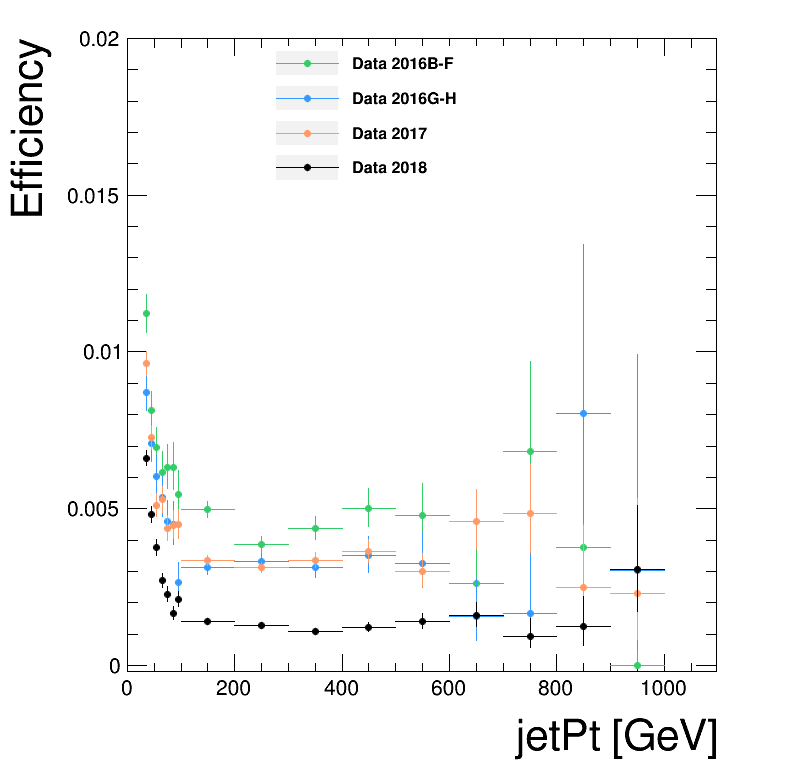

In [14]:

   

color_list = [845,861,806,1,876,597,625]

pEff = {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
#     outf = 'tag_eff_jet_'+var[2]+'_pt100.png'
    outf = 'tag_eff_jet_'+var[2]+'_rebin.png'
#     outf = 'tag_eff_jet_'+var[2]+'.png'
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    i = 0
    for k,v in tree.items(): 
        print(k,v)


        if 'bb' not in k:
#         if 'QCD' in k:
            pEff[k] = var[1][k]
#             pEff[k] = rt.TEfficiency(eta_num_all[k], eta_den_all[k])
#             pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])
            pEff[k].SetTitle("efficiency;"+var[0]+";Efficiency")

            pEff[k].SetLineColor(color_list[i])
            pEff[k].SetMarkerColor(color_list[i])
            pEff[k].SetMarkerSize(0.8)
            pEff[k].SetMarkerStyle(20)

            if i==0:
                pEff[k].Draw("apez")
            else:
                pEff[k].Draw("pezsame")

            rt.gPad.Update()        
            #pEff[k].GetPaintedHistogram().GetXaxis().SetRangeUser(x[0],x[-1])
            pEff[k].GetPaintedGraph().SetMarkerStyle(8)
            pEff[k].GetPaintedGraph().SetMarkerSize(20)        
            pEff[k].GetPaintedGraph().SetLineColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMarkerColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMinimum(var[3])
            pEff[k].GetPaintedGraph().SetMaximum(var[4])
            pEff[k].GetPaintedGraph().GetXaxis().SetLabelSize(0.03)
            pEff[k].GetPaintedGraph().GetYaxis().SetLabelSize(0.03)


#             print('dim: ', pEff[k].GetDimension())
#             print('binN: ', pEff[k].GetPaintedGraph().GetN())
#             print('binN: ', pEff[k].GetPassedHistogram().GetNbinsX())
#             for cnt in range(len(x)):
#                 print(cnt)
#                 print('bin central x value: ', pEff[k].GetPassedHistogram().GetBinCenter(cnt))
#                 print('bin central y value: ', pEff[k].GetEfficiency(cnt))
#                 print('bin error y low: ', pEff[k].GetEfficiencyErrorLow(cnt))
#                 print('bin error y up: ', pEff[k].GetEfficiencyErrorUp(cnt))

            i += 1



            leg.AddEntry(pEff[k],k)

    leg.Draw()

    # c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(plotDir+outf)


var/x_axis jetPt [GeV] name pt range -0.0002 0.02
Data 2016B-F <TTree b'SusyLLPTree' at 0x7f3df3fcddd8>
Data 2016G-H <TTree b'SusyLLPTree' at 0x7f3dc4ffa7b8>
Data 2017 <TTree b'SusyLLPTree' at 0x7f3dc4a4d978>
Data 2018 <TTree b'SusyLLPTree' at 0x7f3dc44e3780>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201015/Data/3years/tag_eff_jet_pt_rebin_logX.png has been created


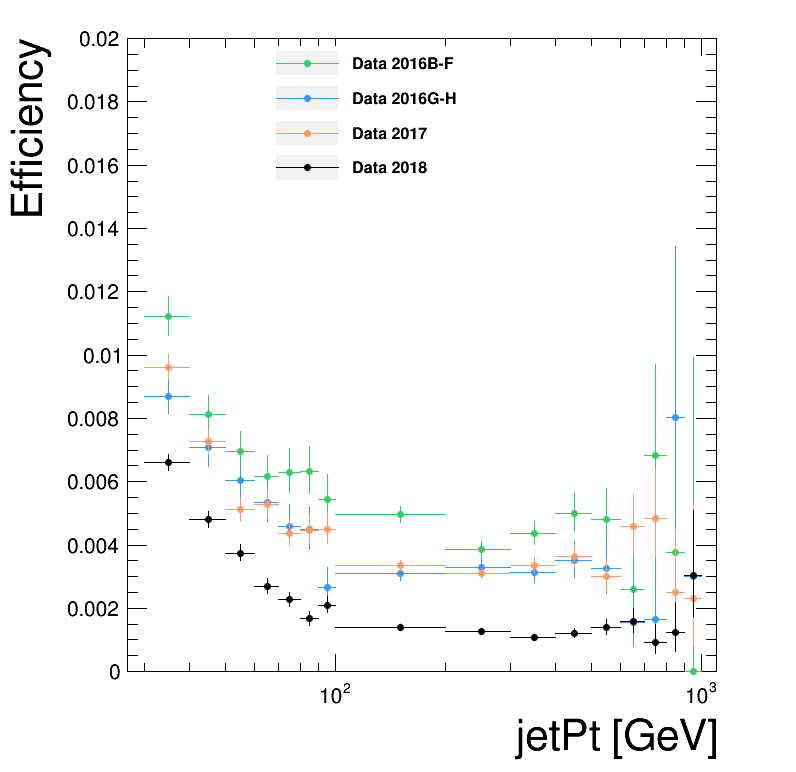

In [15]:

   

color_list = [845,861,806,1,876,597,625]

pEff = {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
#     outf = 'tag_eff_jet_'+var[2]+'_pt100.png'
    outf = 'tag_eff_jet_'+var[2]+'_rebin_logX.png'
#     outf = 'tag_eff_jet_'+var[2]+'.png'
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    i = 0
    for k,v in tree.items(): 
        print(k,v)


        if 'bb' not in k:
#         if 'QCD' in k:
            pEff[k] = var[1][k]
#             pEff[k] = rt.TEfficiency(eta_num_all[k], eta_den_all[k])
#             pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])
            pEff[k].SetTitle("efficiency;"+var[0]+";Efficiency")

            pEff[k].SetLineColor(color_list[i])
            pEff[k].SetMarkerColor(color_list[i])
            pEff[k].SetMarkerSize(0.8)
            pEff[k].SetMarkerStyle(20)

            if i==0:
                pEff[k].Draw("apez")
            else:
                pEff[k].Draw("pezsame")

            rt.gPad.Update()        
            #pEff[k].GetPaintedHistogram().GetXaxis().SetRangeUser(x[0],x[-1])
            pEff[k].GetPaintedGraph().SetMarkerStyle(8)
            pEff[k].GetPaintedGraph().SetMarkerSize(20)        
            pEff[k].GetPaintedGraph().SetLineColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMarkerColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMinimum(var[3])
            pEff[k].GetPaintedGraph().SetMaximum(var[4])
            pEff[k].GetPaintedGraph().GetXaxis().SetLabelSize(0.03)
            pEff[k].GetPaintedGraph().GetYaxis().SetLabelSize(0.03)


#             print('dim: ', pEff[k].GetDimension())
#             print('binN: ', pEff[k].GetPaintedGraph().GetN())
#             print('binN: ', pEff[k].GetPassedHistogram().GetNbinsX())
#             for cnt in range(len(x)):
#                 print(cnt)
#                 print('bin central x value: ', pEff[k].GetPassedHistogram().GetBinCenter(cnt))
#                 print('bin central y value: ', pEff[k].GetEfficiency(cnt))
#                 print('bin error y low: ', pEff[k].GetEfficiencyErrorLow(cnt))
#                 print('bin error y up: ', pEff[k].GetEfficiencyErrorUp(cnt))

            i += 1



            leg.AddEntry(pEff[k],k)

    leg.Draw()

    c.SetLogx()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(plotDir+outf)
